# CNN Text Classification

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras

nltk.download('punkt')

[nltk_data] Downloading package punkt to E:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# 윈도우즈에서는 개별 다운로드 
# if not os.path.exists("Stanford_politeness_corpus.zip"):
#   !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

# if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
#   !unzip Stanford_politeness_corpus.zip

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
unzip:  cannot find or open Stanford_politeness_corpus.zip, Stanford_politeness_corpus.zip.zip or Stanford_politeness_corpus.zip.ZIP.


In [3]:
def load_data(data_file):
  data = pd.read_csv(data_file)

  quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75])
  print(quantiles)

  for i in range(len(data)):
    score = data.loc[i, "Normalized Score"]
    if score <= quantiles[0.25]:    # Bottom quartile (impolite).
      data.loc[i, "Normalized Score"] = 0
    elif score >= quantiles[0.75]:   # Top quartile (polite).
      data.loc[i, "Normalized Score"] = 1
    else:                            # Neutral.
      data.loc[i, "Normalized Score"] = 2

  data["Normalized Score"] = data["Normalized Score"].astype(int)

  data = data[data["Normalized Score"] < 2]    # Discard neutral examples.
  data = data.sample(frac=1).reset_index(drop=True)

  return data

In [4]:
data = load_data("Stanford_politeness_corpus/wikipedia.annotated.csv")
pd.set_option('display.max_columns', None)

print(data.head())

0.25   -0.442633
0.50    0.052339
0.75    0.514399
Name: Normalized Score, dtype: float64
   Community      Id                                            Request  \
0  Wikipedia  629713  Notability is an issue of common sense: you're...   
1  Wikipedia  190312  I think I lot of the things on the Methuselah ...   
2  Wikipedia  472209  Sounds like a great idea. Do you want to propo...   
3  Wikipedia  629967                         Huh? Who the hell are you?   
4  Wikipedia  338160  <url> as having been deleted via a deletion di...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13      15       7       7       5  A1RPVYUPJZGM9Z  A21753FQKCM5DQ   
1      13      20      20      21      21  A233ONYNWKDIYF   AO5E3LWBYM72K   
2      21      17      17      17      20  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3       6       4       5       1       6   AYG3MF094634L  A1F4D2PZ7NNWTL   
4      17      17      17      19      13  A233ONYNWKDIYF  A2EJ6MKRFATU5I 

### 사전을 구성

1.   문장들을 소문자로 바꾸고, tokenization (nltk.tokenize 패키지의 word_tokenize  함수 활용)
2.   전체 데이터에서 각 토큰들의 등장 빈도 확인 (collections 패키지의 Counter  클래스 활용)
3.   가장 등장 빈도가 높은 단어를 vocab_size 만큼 선택 (Counter의 most_common 함수 활용)
4.   각각의 단어에 고유한 숫자 부여. 이때, 0번째 토큰은 "<PAD>", 1번째 토큰은 "<OOV>" 할당
5.   토큰 -> 숫자 변환을 위한 dictionary (word_index 변수에 할당)와, 숫자 -> 토큰 변환을 위한 dictionary (word_inverted_index 변수에 할당) 생성
  
  



In [5]:
# we assign the first indices in the vocabulary to special tokens that we use
# for padding, and for indicating unknown words
vocab_size = 5000
pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
  word_counter = Counter()

  for sent in sentences:
    tokens = word_tokenize(sent.lower())
    word_counter.update(tokens)
  
  most_common = word_counter.most_common()
  print("고빈도 단어:")
  for k, v in most_common[:10]:
    print(k, ": ", v)
  
  vocab = {
      '<PAD>': pad_id,
      '<OOV>': oov_id
  }
  for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
    vocab[word] = i
    if len(vocab) >= vocab_size:
      break
  
  return vocab

vocab_size = 5000
pad_id = 0
oov_id = 1
index_offset = 1

sentences = data["Request"].tolist()
word_index = make_vocab(sentences)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
  print(i, word_inverted_index[i])
  
print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
? :  2714
the :  2502
you :  2239
, :  2204
to :  1698
i :  1683
. :  1636
a :  1127
it :  964
that :  936

단어 사전:
0 <PAD>
1 <OOV>
2 ?
3 the
4 you
5 ,
6 to
7 i
8 .
9 a

단어 사전 크기:  5000


### 사전이 정상적인지 체크 

사전이 잘 구성되고, 각각의 사전이 word_index 변수와 word_inverted_index 변수에 할당되었다면 문장이 숫자로 변환되었다가 다시 원래 문장으로 돌아오는 것을 확인

In [6]:
def index_to_text(indexes):
  return ' '.join([word_inverted_index[i] for i in indexes])
  
def text_to_index(text):
  tokens = tokens = word_tokenize(text.lower())
  indexes = []
  for tok in tokens:
    if tok in word_index:
      indexes.append(word_index[tok])
    else:
      indexes.append(oov_id)
      
  return indexes

print("원본: ", sentences[0])
ids = text_to_index(sentences[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  Notability is an issue of common sense: you're writing for other people, so what is notable for you (or me) is not that relevant. My local shop is more important and notable ''to me'' than Wal-mart, but who, other than me, actually cares?
문자 -> 숫자:  [372, 15, 55, 282, 12, 650, 344, 59, 4, 105, 550, 19, 93, 149, 5, 51, 26, 15, 387, 19, 4, 54, 44, 38, 46, 15, 31, 11, 709, 8, 52, 2615, 1718, 15, 81, 517, 16, 387, 24, 6, 38, 22, 117, 2616, 5, 42, 94, 5, 93, 117, 38, 5, 190, 1319, 2]
숫자 -> 문자:  notability is an issue of common sense : you 're writing for other people , so what is notable for you ( or me ) is not that relevant . my local shop is more important and notable `` to me '' than wal-mart , but who , other than me , actually cares ?


숫자로 바뀐 문장들을 학습 데이터로 사용할 수 있도록 변형


1.   모든 문장들을 동일한 길이가 되도록 padding 처리하거나 자름 (tensorflow.python.keras.preprocessing.sequence 패키지의 pad_sequence 함수 활용)
2.   데이터의 일부(10%)를 테스트 데이터로 분리



In [7]:
x_variable = [text_to_index(sent) for sent in sentences]

sentence_size = 200
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

n_test = len(data) // 10
test_inputs = x_padded[:n_test]
train_inputs = x_padded[n_test:]

ys = np.array(data["Normalized Score"].tolist())
test_labels = ys[:n_test]
train_labels = ys[n_test:]

print("test_inputs shape: ", test_inputs.shape)
print("train_inputs shape: ", train_inputs.shape)
print("test_labels shape: ", test_labels.shape)
print("train_labels shape: ", train_labels.shape)

test_inputs shape:  (217, 200)
train_inputs shape:  (1961, 200)
test_labels shape:  (217,)
train_labels shape:  (1961,)


### 모델링

In [8]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

### 학습 결과를 시각화, 성능을 측정하는 함수

In [9]:
def plot_loss(history):
  plt.figure(figsize=(6,5))
  val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
  plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  
def eval_model(model):
  test_loss, test_acc = model.evaluate(test_inputs, test_labels)
  print('Test accuracy:', test_acc)

### 학습

Epoch 1/10
62/62 [==============================] - 1s 17ms/step - loss: 0.6778 - accuracy: 0.5961 - val_loss: 0.6420 - val_accuracy: 0.7742
Epoch 2/10
62/62 [==============================] - 1s 14ms/step - loss: 0.5728 - accuracy: 0.8027 - val_loss: 0.4989 - val_accuracy: 0.8157
Epoch 3/10
62/62 [==============================] - 1s 13ms/step - loss: 0.4128 - accuracy: 0.8531 - val_loss: 0.3961 - val_accuracy: 0.8249
Epoch 4/10
62/62 [==============================] - 1s 13ms/step - loss: 0.2995 - accuracy: 0.9026 - val_loss: 0.3659 - val_accuracy: 0.8341
Epoch 5/10
62/62 [==============================] - 1s 13ms/step - loss: 0.2119 - accuracy: 0.9393 - val_loss: 0.3508 - val_accuracy: 0.8295
Epoch 6/10
62/62 [==============================] - 1s 13ms/step - loss: 0.1456 - accuracy: 0.9648 - val_loss: 0.3534 - val_accuracy: 0.8387
Epoch 7/10
62/62 [==============================] - 1s 13ms/step - loss: 0.0958 - accuracy: 0.9842 - val_loss: 0.3559 - val_accuracy: 0.8249
Epoch 8/10
62

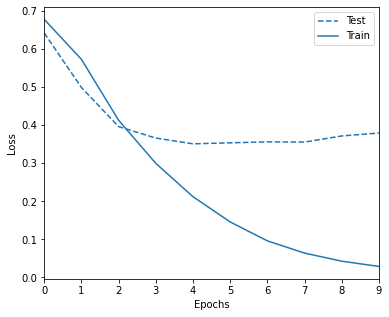

In [10]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

## Pretrained word vectors

만들어진 모델에 미리 학습된 단어 벡터(GloVe)

In [0]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip
    
! head glove.6B.50d.txt

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

GloVe 벡터를 불러와서 임베딩 행렬을 초기화 

1.   GloVe 파일을 읽고, 각 줄에서 단어(1번째 토큰)와 벡터를 이루는 숫자들(2번째 이후 토큰들)을 분리
2.   벡터를 이루는 숫자들을 numpy 행렬로 변환 (numpy의 asarray 함수 활용)
3.   단어와 벡터를 연결하는 dictionary 자료구조 구성 (단어 -> 벡터)
4.   모든 단어들에 대한 임베딩 행렬을 무작위로 생성 (vocab_size X 50 크기의 numpy 행렬)
5.   임베딩 행렬에서, GloVe 벡터가 존재하는 단어들만 해당 GloVe 벡터로 대체



In [13]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, 50))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 4478/5000 words.


위의 모델에서, Embedding layer의 값을 위에서 생성한 임베딩 행렬로 초기화
(keras.initializers.Constant 클래스 활용)


In [14]:
glove_init = keras.initializers.Constant(embedding_matrix)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50, embeddings_initializer=glove_init),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Epoch 1/10
62/62 [==============================] - 1s 16ms/step - loss: 0.7197 - accuracy: 0.5584 - val_loss: 0.6723 - val_accuracy: 0.6129
Epoch 2/10
62/62 [==============================] - 1s 13ms/step - loss: 0.5770 - accuracy: 0.7139 - val_loss: 0.6203 - val_accuracy: 0.6728
Epoch 3/10
62/62 [==============================] - 1s 13ms/step - loss: 0.4766 - accuracy: 0.8123 - val_loss: 0.5715 - val_accuracy: 0.7419
Epoch 4/10
62/62 [==============================] - 1s 13ms/step - loss: 0.3994 - accuracy: 0.8638 - val_loss: 0.5416 - val_accuracy: 0.7742
Epoch 5/10
62/62 [==============================] - 1s 13ms/step - loss: 0.3280 - accuracy: 0.9159 - val_loss: 0.5077 - val_accuracy: 0.7834
Epoch 6/10
62/62 [==============================] - 1s 13ms/step - loss: 0.2704 - accuracy: 0.9408 - val_loss: 0.5079 - val_accuracy: 0.7880
Epoch 7/10
62/62 [==============================] - 1s 13ms/step - loss: 0.2270 - accuracy: 0.9536 - val_loss: 0.4752 - val_accuracy: 0.8018
Epoch 8/10
62

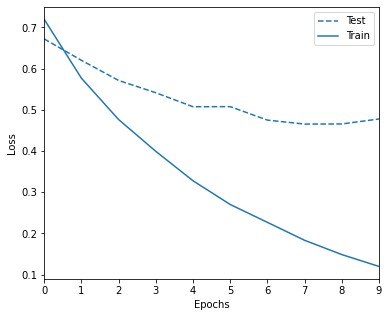

In [15]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)